In [6]:
from __future__ import print_function, division
from keras.datasets import fashion_mnist
from keras.layers import (
    Input,
    Dense,
    Reshape,
    Flatten,
    Dropout,
    BatchNormalization,
    Activation,
    ZeroPadding2D,
    LeakyReLU,
)
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
(training_data, _), (_, _) = fashion_mnist.load_data()

X_train = training_data / 127.5 - 1
X_train = np.expand_dims(X_train, axis=3)

ValueError: ignored

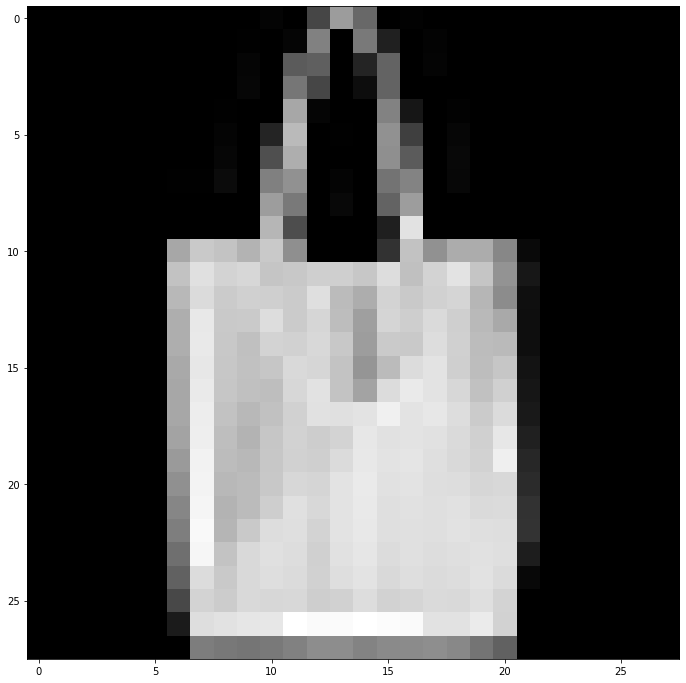

In [4]:
# visualize the image matrix
def visualize_input(img, ax):
  ax.imshow(img, cmap='gray')
  width, height = img.shape
  thresh = img / 2.5
  for x in range(width):
    for y in range(height):
      ax.annotate(
          str(round(img[x][y],2)), xy=(y,x),
          horizontalalignment="center",
          verticalalignment="center",
          color="white" if img[x][y]<thresh else "black"
      )

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
visualize_input(training_data[3343], ax)

#  BUILD THE GENERATOR

In [5]:
def build_generator():
  # Instantiates a sequential model and names it generator
  generator = Sequential()
  # Adds the dense layer that has a number of neurons = 128 × 7 × 7
  generator.add(Dense(128 * 7 * 7, activation="relu", input_dim=100))
  # Reshapes the image dimensions to 7 × 7 × 128 
  generator.add(Reshape((7, 7, 128)))
  # Upsampling layer to double the size of the image dimensions to 14 × 14
  generator.add(UpSampling2D())
  generator.add(Conv2D(128, kernel_size=3, padding="same", activation="relu"))
  generator.add(BatchNormalization(momentum=0.8))
  # Upsamples the image dimensions to 28 × 28
  generator.add(UpSampling2D())

  # convolutional + batch normalization layers
  generator.add(Conv2D(64, kernel_size=3, padding="same", activation="relu"))
  generator.add(BatchNormalization(momentum=0.8))
  # convolutional layer with filters = 1
  # We don’t add upsampling here because the image size of 28 × 28 is equal to
  #  the image size in the MNIST dataset. You can adjust this for your own 
  # problem.
  generator.add(Conv2D(1, kernel_size=3, padding="same", activation="relu"))

  generator.summary()

  noise = Input(shape=(100,))
  # Runs the generator model to create the fake image 
  fake_image = generator(noise)
  
  # Returns a model that takes the noise vector as an input and 
  # outputs the fake image
  return Model(inputs=noise, outputs=fake_image)

# BUILD THE DISCRIMINATOR

In [7]:
def build_discriminator():
  discriminator = Sequential()
  # Adds a convolutional layer to the discriminator model
  discriminator.add(
      Conv2D(
          32, 
          kernel_size=3,
           strides=2,
           input_shape=(28,28,1), 
           padding="same"
           )
      )
  # Adds a leaky ReLU activation function
  discriminator.add(LeakyReLU(alpha=0.2))
  # Adds a dropout layer with a 25% dropout probability
  discriminator.add(Dropout(0.25))
  # Adds a second convolutional layer with zero padding
  discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
  discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
  discriminator.add(BatchNormalization(momentum=0.8))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.25))

  discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
  discriminator.add(BatchNormalization(momentum=0.8))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.25))

  discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
  discriminator.add(BatchNormalization(momentum=0.8))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.25))

  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation='sigmoid'))

  discriminator.summary()

  img = Input(shape= (28,28,1))
  probability = discriminator(img)

  return Model(img, probability)


# BUILD THE COMBINED MODEL

In [8]:
# define the optimizer
optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
# Builds and compiles the discriminator
discriminator = build_discriminator()
discriminator.compile(
    loss="binary_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
)
# Freezes the discriminator weights because we don’t want 
# to train it during generator training
discriminator.trainable = False

# Build the generator
generator = build_generator()

# The generator takes noise as input with latent_dim = 100
# and generates images.
z = Input(shape=(100,))
img = generator(z)

# The discriminator takes generated images
# as input and determines their validity.
valid = discriminator(img)

# The combined model (stacked generator and discriminator)
# trains the generator to fool the discriminator
combined = Model(inputs=z, outputs=valid)
combined.compile(loss="binary_crossentropy", optimizer=optimizer)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 zero_padding2d (ZeroPadding  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 64)         256       
 ormalization)                                          

# BUILD THE TRAINING FUNCTION

In [12]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [13]:
def train(epochs, batch_size=128, save_interval=50):

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Sample noise and generate a batch of new images
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)

        # Train the discriminator (real classified as ones and generated as zeros)
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Train the generator (wants discriminator to mistake images as real)
        g_loss = combined.train_on_batch(noise, valid)

        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            plot_generated_images(epoch, generator)

1/1 [==============================] - 0s 138ms/step
0 [D loss: 0.515580, acc.: 73.44%] [G loss: 0.756244]
1/1 [==============================] - 0s 133ms/step
1 [D loss: 0.268634, acc.: 96.88%] [G loss: 0.811394]
1/1 [==============================] - 0s 134ms/step
2 [D loss: 0.259140, acc.: 95.31%] [G loss: 0.849514]
1/1 [==============================] - 0s 129ms/step
3 [D loss: 0.139773, acc.: 100.00%] [G loss: 0.961490]
1/1 [==============================] - 0s 136ms/step
4 [D loss: 0.071168, acc.: 100.00%] [G loss: 1.111331]
1/1 [==============================] - 0s 138ms/step
5 [D loss: 0.083468, acc.: 98.44%] [G loss: 1.199826]
1/1 [==============================] - 0s 129ms/step
6 [D loss: 0.040218, acc.: 100.00%] [G loss: 1.343712]
1/1 [==============================] - 0s 137ms/step
7 [D loss: 0.073344, acc.: 100.00%] [G loss: 1.491067]
1/1 [==============================] - 0s 133ms/step
8 [D loss: 0.051362, acc.: 100.00%] [G loss: 1.373210]
1/1 [===========================

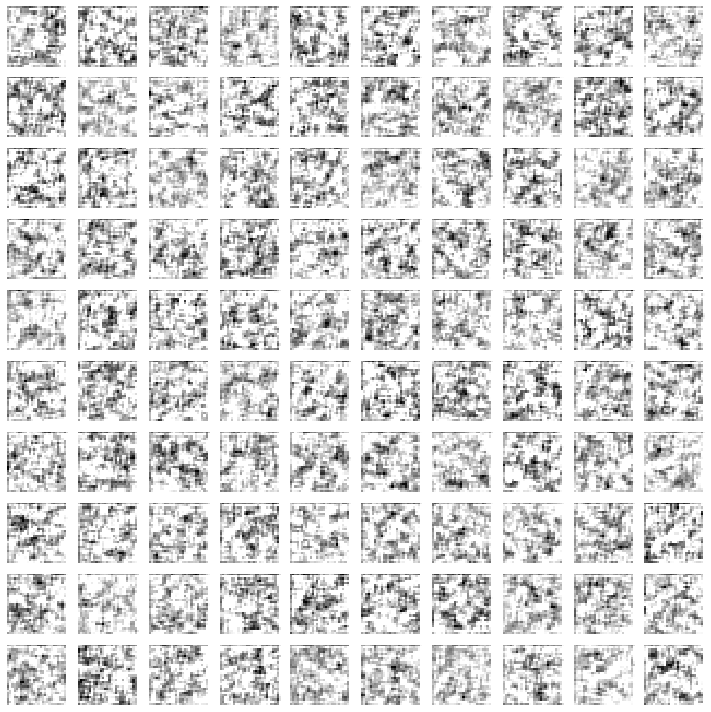

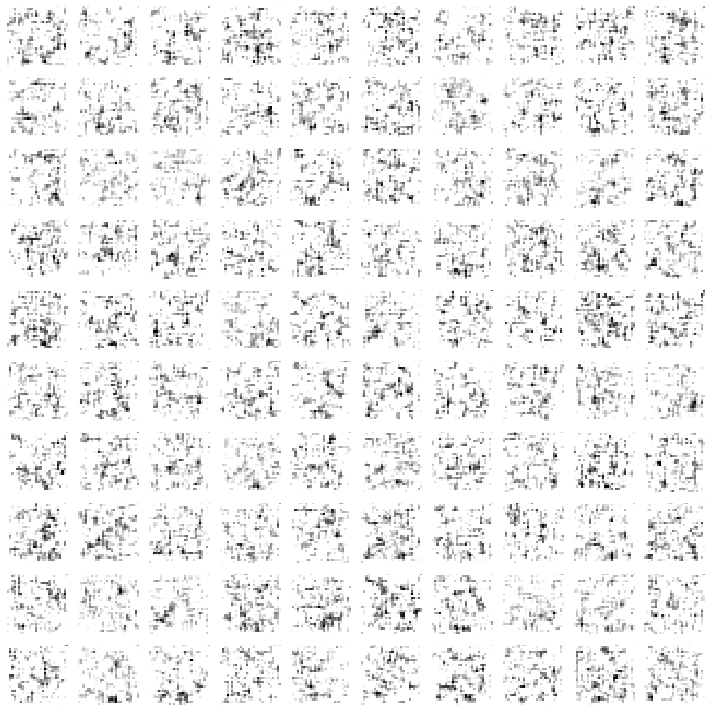

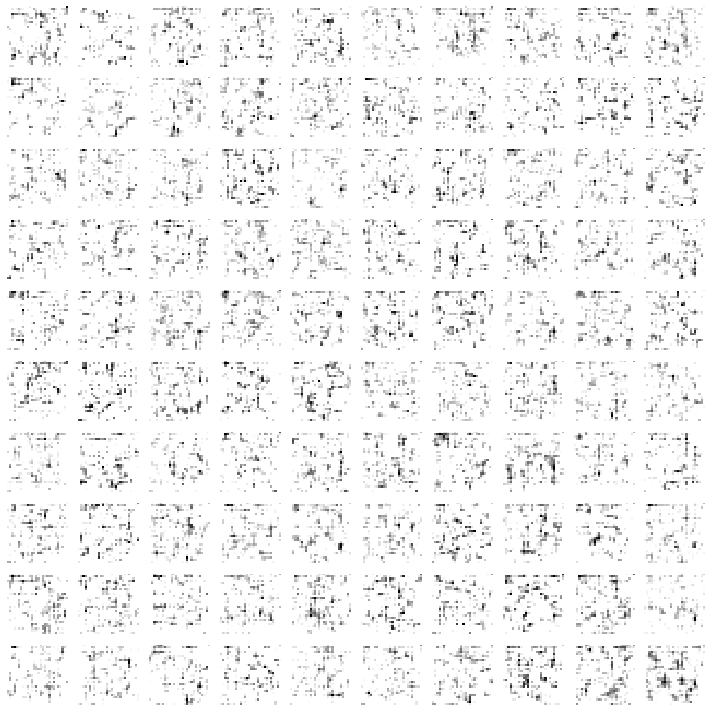

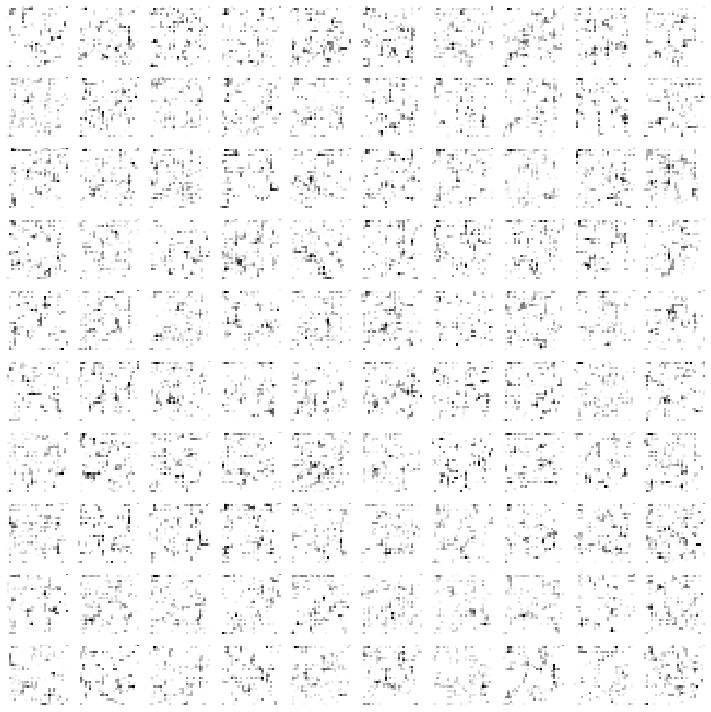

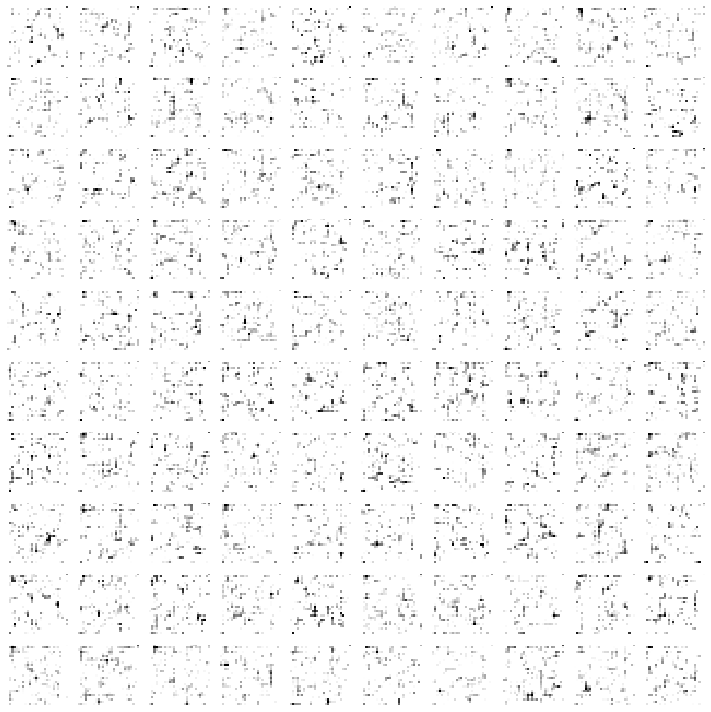

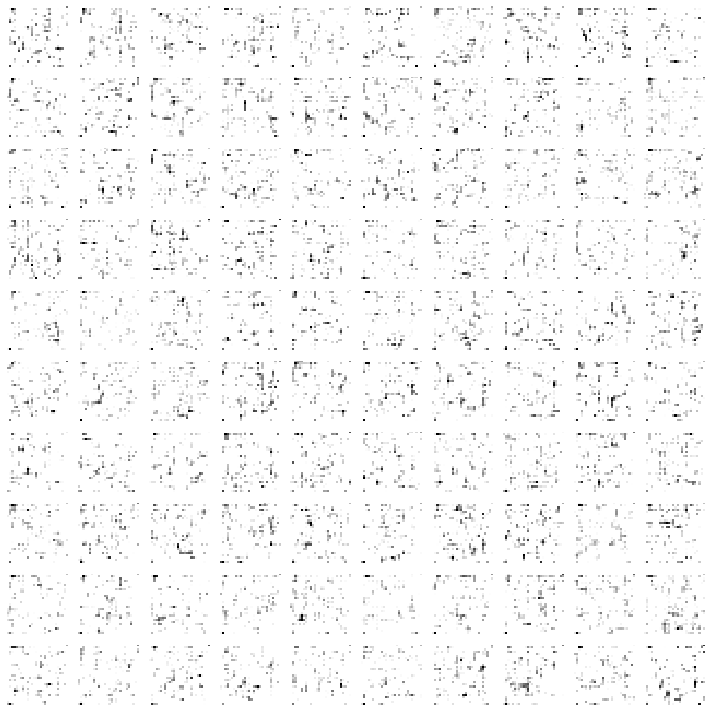

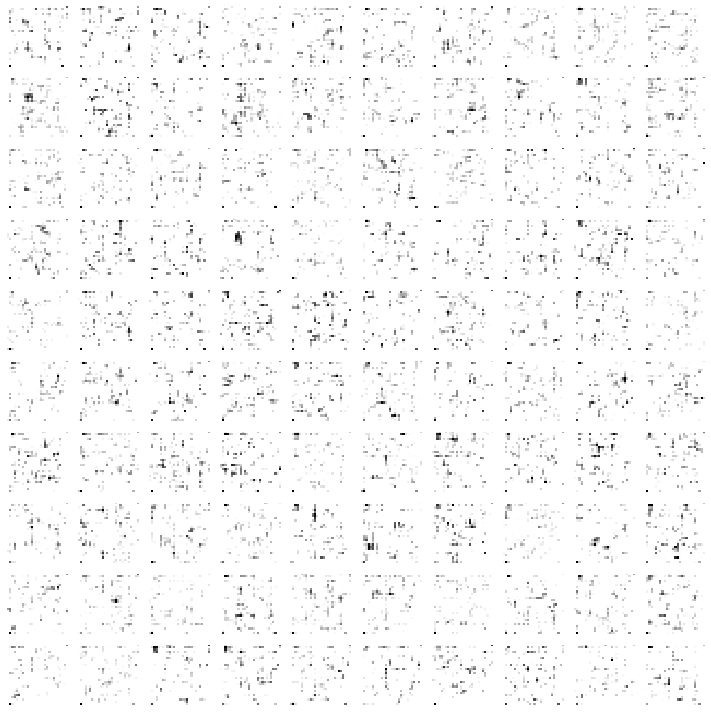

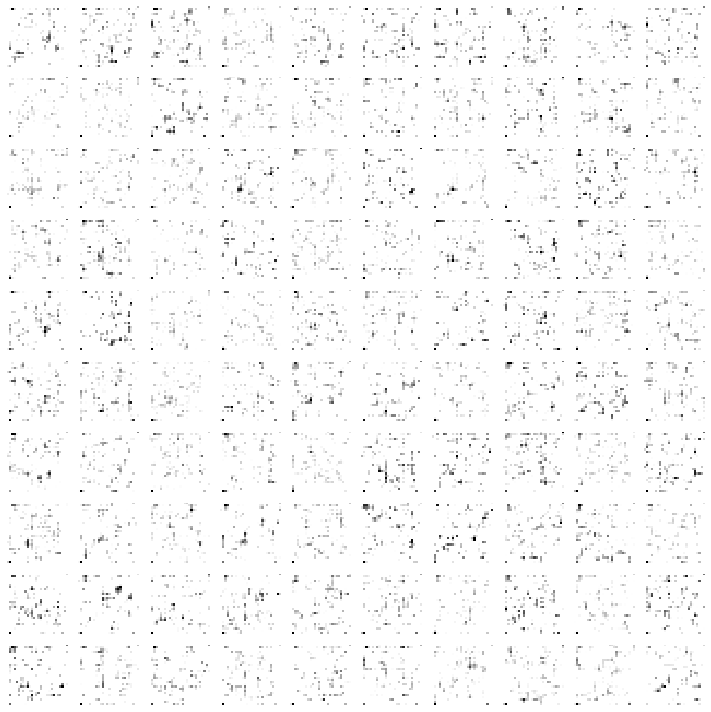

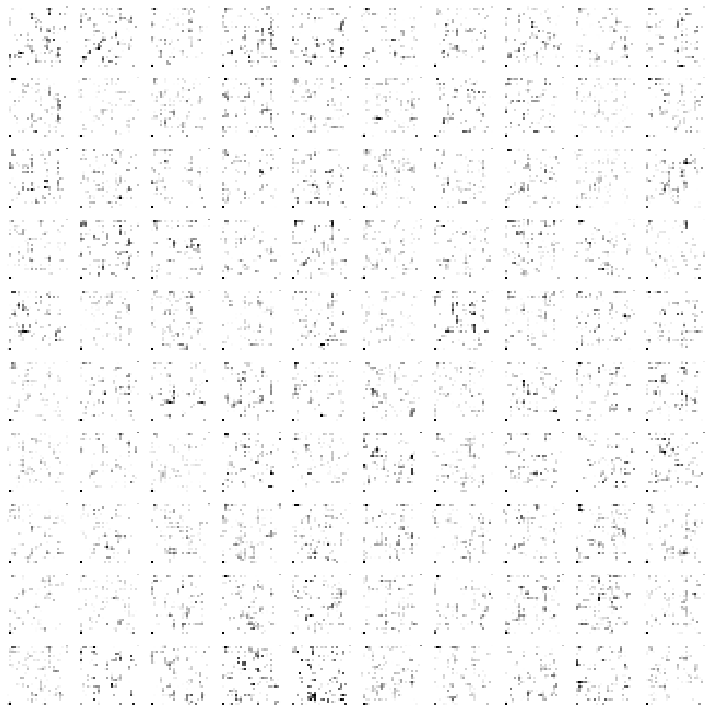

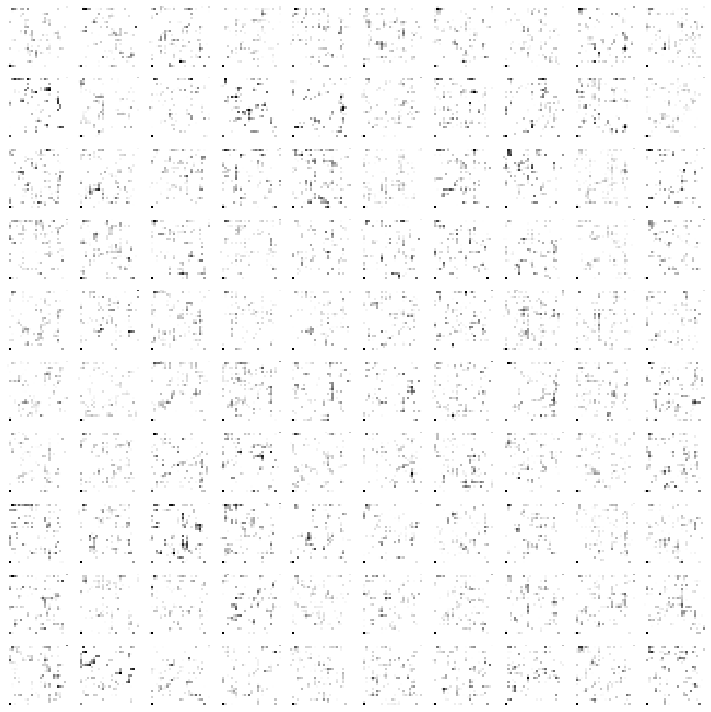

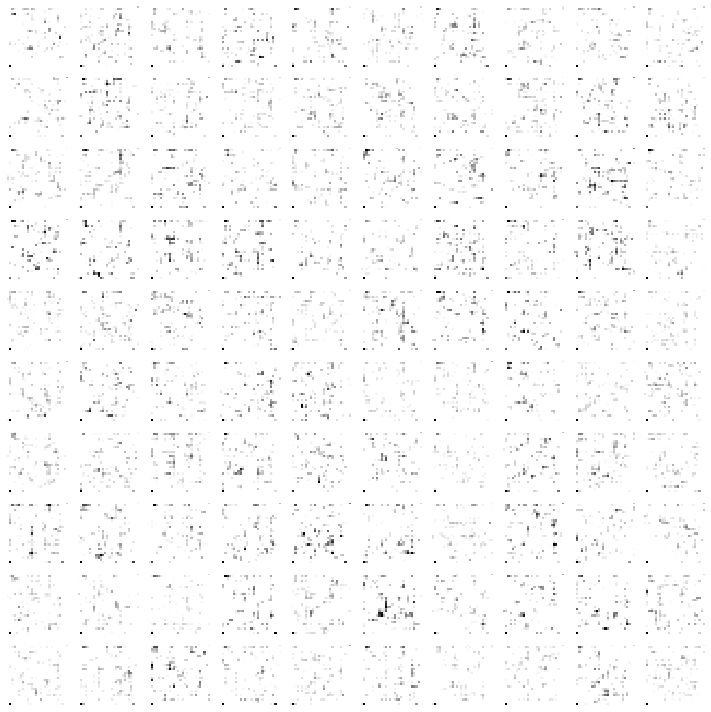

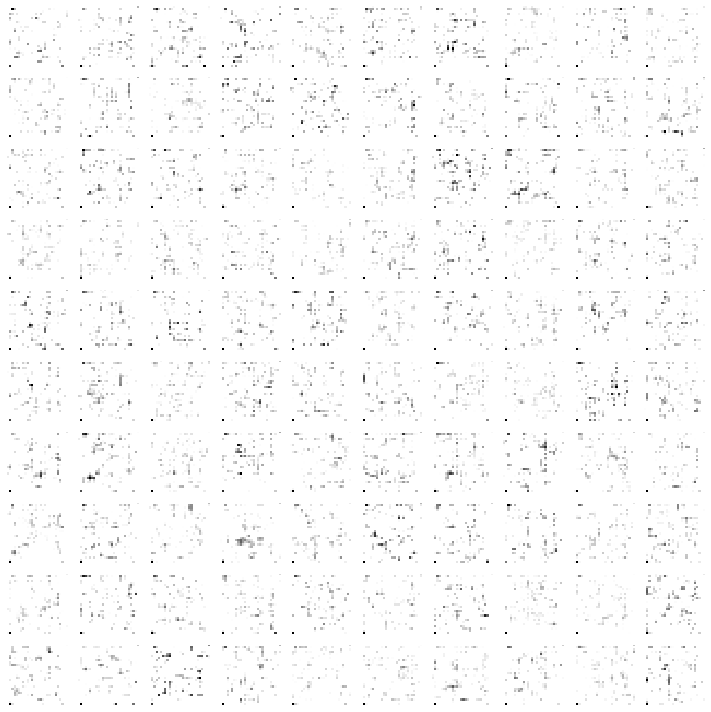

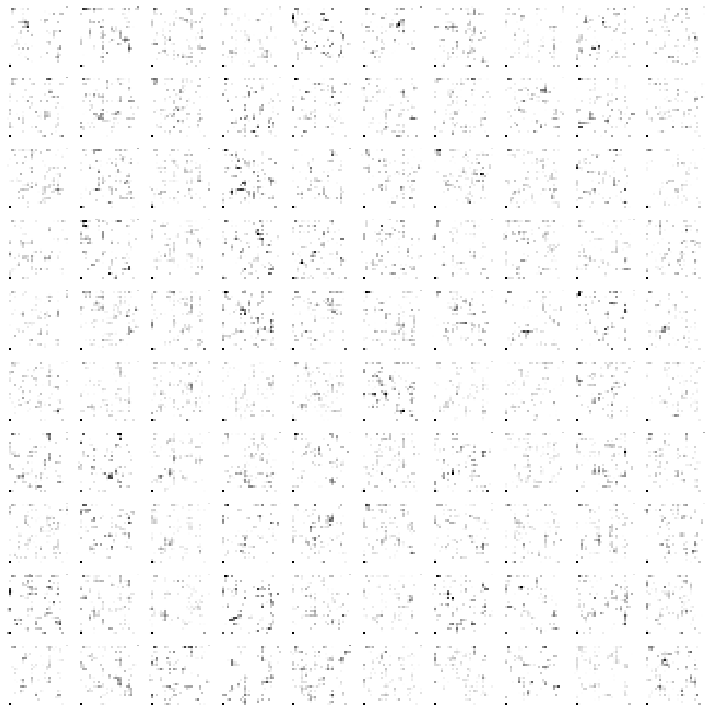

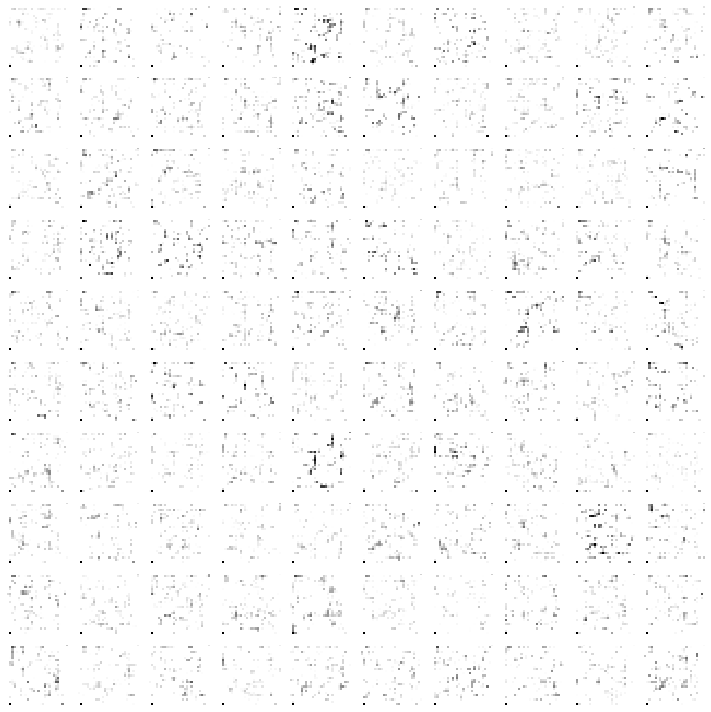

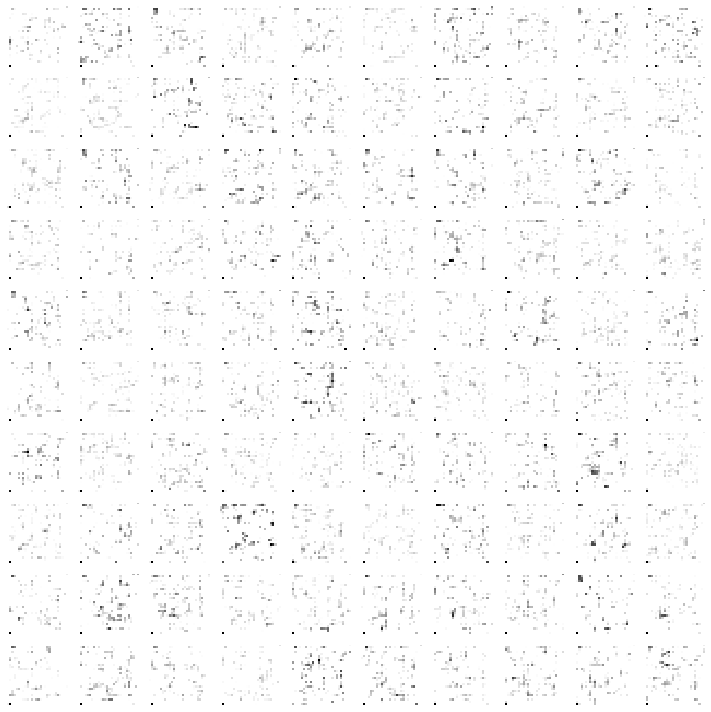

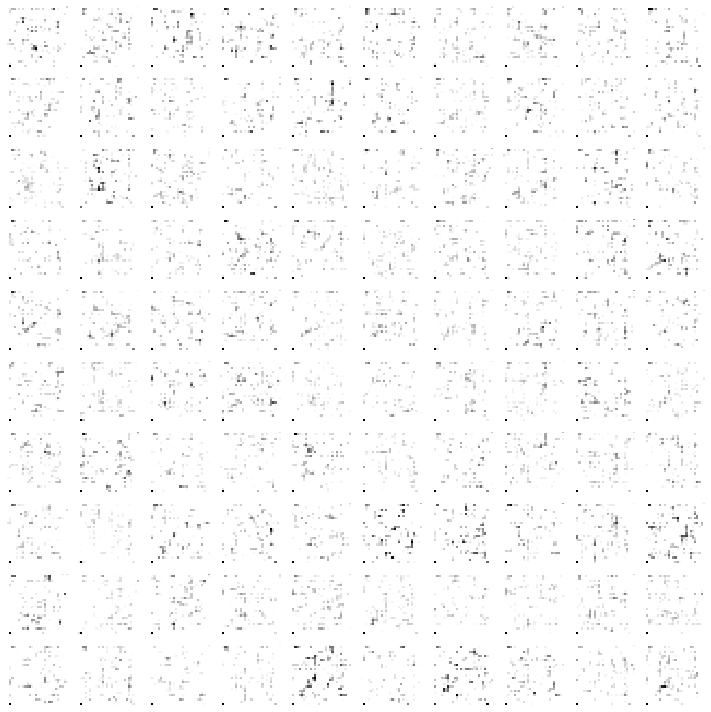

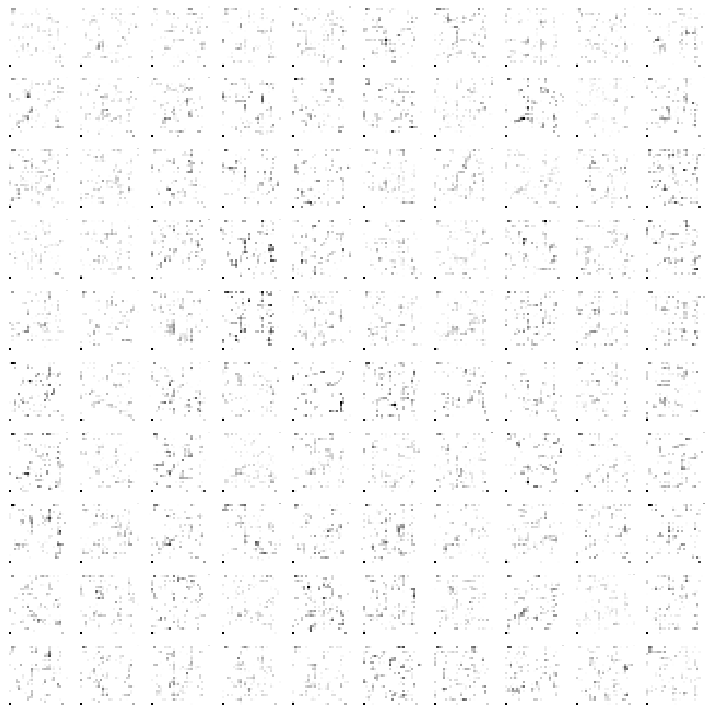

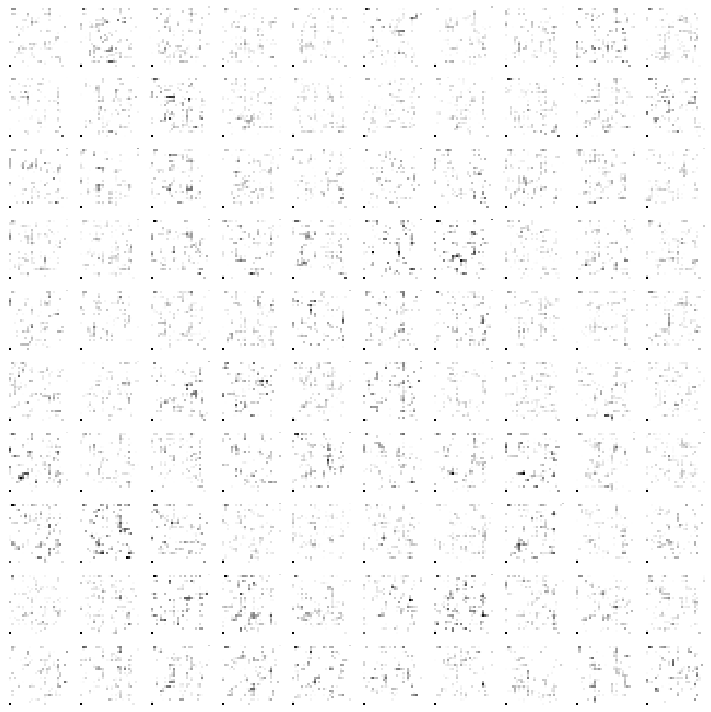

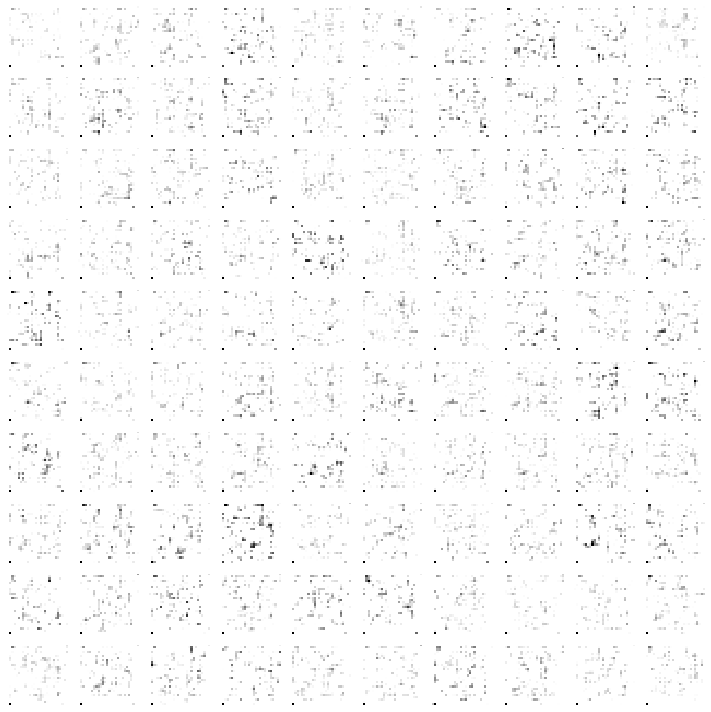

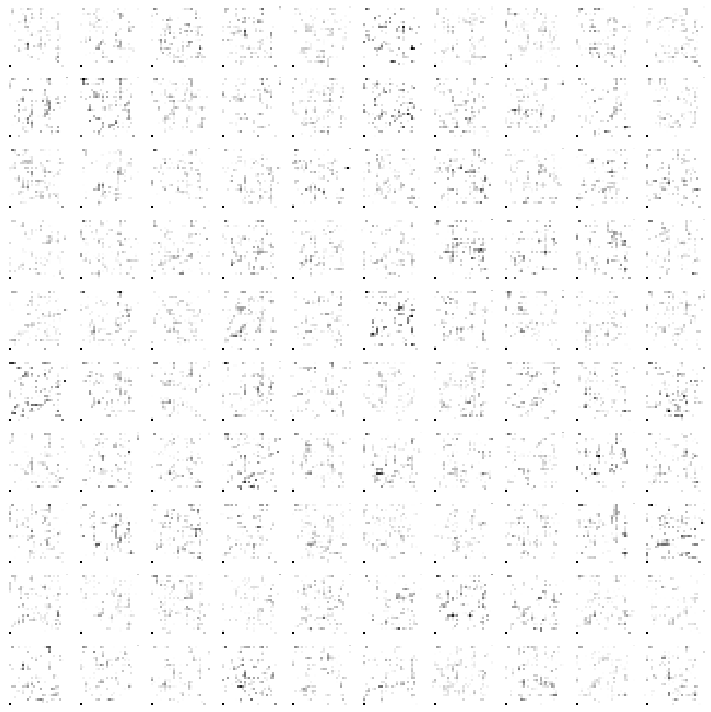

In [14]:
train(epochs=1000, batch_size=32, save_interval=50)